# Event identification

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from datetime import datetime
import os
import rioxarray
import pickle

# Perth shape file

In [5]:
# File paths
base_path = "/g/data/w28/yk8692/nesp"
region_name = "Perth"
df = pd.read_excel(f'{base_path}/station/All_stations_information.xlsx')
# Load the Australian GCCSA shapefile
shapefile_path = f"{base_path}/testing_script/GCCSA_2021_AUST_SHP_GDA2020/GCCSA_2021_AUST_GDA2020.shp"

# csv_file_path = "/g/data/gb02/lk5320/DATA_stored/All_stations_information.xlsx"  
# shapefile_path = '/scratch/gb02/lk5320/python_scripts/BARRA/Perth_radar/shp_perth/GCCSA_2021_AUST_GDA2020.shp'  # Replace with your path
# # output_file_path = "/scratch/gb02/lk5320/DATA/2_greater_SYD_stations.csv"

# df = pd.read_excel(csv_file_path)

In [6]:
# Assuming df is your DataFrame with 'Longitude' and 'Latitude' columns
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Load the shapefile (Greater Sydney boundary)
gdf_shapefile = gpd.read_file(shapefile_path)

# Select only the first geometry (Greater Sydney boundary) from the shapefile
greater_sydney_geom = gdf_shapefile.iloc[16]  # Assuming there's only one polygon for Greater Sydney

# Create a GeoSeries for the Greater Sydney polygon
sydney_polygon = gpd.GeoSeries([greater_sydney_geom.geometry], crs=gdf_shapefile.crs)

# Shortlisted events from excel sheet

In [7]:
events_list = f"{base_path}/figure/{region_name}_top10_extreme_events_ranked_with_latlon_formatted.csv"  
# events_list = "/scratch/gb02/lk5320/python_scripts/Station_analysis/plots_4_04march2025/p5_shortlist_common_events_based_on_1hr.xlsx"  
events_list = pd.read_csv(events_list)

In [8]:
events_list

,Sr. no.,Time of 10min P,Precipitation at 10min,Time of 1hr P,Precipitation at 1hr,station name,Longitude,Latitude
0,1,2007-12-26 20:55:00,49.6,2007-12-26 21:00:00,116.0,PEARCE RAAF,116.0189,-31.6669
1,2,2007-12-29 05:50:00,48.6,2007-12-29 04:55:00,142.4,PEARCE RAAF,116.0189,-31.6669
2,3,2014-10-18 16:15:00,23.4,2014-10-18 16:50:00,29.0,SWANBOURNE,115.7619,-31.9560
3,4,2010-03-22 17:15:00,23.0,2010-03-22 17:35:00,35.6,PERTH AIRPORT,115.9764,-31.9275
4,5,2010-03-22 17:10:00,20.4,2010-03-22 17:55:00,30.6,PERTH METRO,115.8728,-31.9192
5,6,2009-10-15 10:50:00,21.4,2009-10-15 11:00:00,64.0,PEARCE RAAF,116.0189,-31.6669
6,7,2012-11-24 18:20:00,20.4,2012-11-24 18:40:00,26.0,PERTH AIRPORT,115.9764,-31.9275
7,8,2004-01-31 14:25:00,19.4,2004-01-31 14:25:00,19.4,PERTH AIRPORT,115.9764,-31.9275
8,9,2002-03-31 11:50:00,18.6,2002-03-31 12:10:00,19.4,PERTH AIRPORT,115.9764,-31.9275
9,10,2003-02-02 07:30:00,18.4,2003-02-02 07:40:00,18.4,ROTTNEST ISLAND,115.5022,-32.0069


In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

# Define your RGB colors
rgb_colors = np.array([
    [255, 255, 255],
    [235, 246, 255],
    [214, 226, 255],
    [181, 201, 255],
    [142, 178, 255],
    [127, 150, 255],
    [114, 133, 248],
    [99, 112, 248],
    [0, 158, 30],
    [60, 188, 61],
    [179, 209, 110],
    [185, 249, 110],
    [255, 249, 19],
    [255, 163, 9],
    [229, 0, 0],
    [189, 0, 0],
    [129, 0, 0],
    [0, 0, 0],
]) / 255.0  # Normalize to [0, 1]

# Create the colormap
custom_cmap = ListedColormap(rgb_colors, name='custom_precip_cmap')

# Radar plots (Radar 12 - perth (1997-2010) and 26 Perth AP(2008-2024))

In [10]:
# Step 1: Convert dBZ to instantaneous rain rate (mm/h)
def dBZ_to_rain_rate_mm_per_hr(ref):
    """
    Convert reflectivity (dBZ) to instantaneous rain rate (mm/h)
    using a Marshall–Palmer-like relation.
    """
    Z = 10 ** (ref / 10.0)
    R_mm_per_hr = (Z / 249.9) ** (1 / 1.49)
    return R_mm_per_hr

In [11]:
# 1) Build the list of max‐rain‐rate fields
max_rain_rates = []

for i in range(15):
    try:
        # Get event date
        event_time = pd.to_datetime(events_list.loc[i, 'Time of 1hr P'])
        selected_date = event_time.strftime('%Y%m%d')

        # File paths
        base_path_12 = f"/g/data/rq0/level_2/12/COLUMNMAXREFLECTIVITY/12_{selected_date}_columnmaxreflectivity.nc"
        base_path_70 = f"/g/data/rq0/level_2/70/COLUMNMAXREFLECTIVITY/70_{selected_date}_columnmaxreflectivity.nc"
        base_path_26 = f"/g/data/rq0/level_2/26/COLUMNMAXREFLECTIVITY/26_{selected_date}_columnmaxreflectivity.nc"


        # Choose existing file
        if os.path.exists(base_path_12):
            ds = xr.open_dataset(base_path_12)
        elif os.path.exists(base_path_70):
            ds = xr.open_dataset(base_path_70)
        elif os.path.exists(base_path_26):
            ds = xr.open_dataset(base_path_26)
        else:
            print(f"No file for {selected_date}")
            max_rain_rates.append(None)
            continue

        # Rename 2D coords to lat/lon if needed
        if 'latitude' in ds.coords:
            ds = ds.rename({'latitude': 'lat'})
        if 'longitude' in ds.coords:
            ds = ds.rename({'longitude': 'lon'})

        # Compute rain rate & max over time
        rain_rate = dBZ_to_rain_rate_mm_per_hr(ds['columnmaxreflectivity'])
        max_rain = rain_rate.max(dim='time')

        max_rain_rates.append(max_rain)

    except Exception as e:
        print(f"Error on index {i} ({selected_date}): {e}")
        max_rain_rates.append(None)

Error on index 11 (20110720): 11
Error on index 12 (20110720): 12
Error on index 13 (20110720): 13
Error on index 14 (20110720): 14


# top 10 events

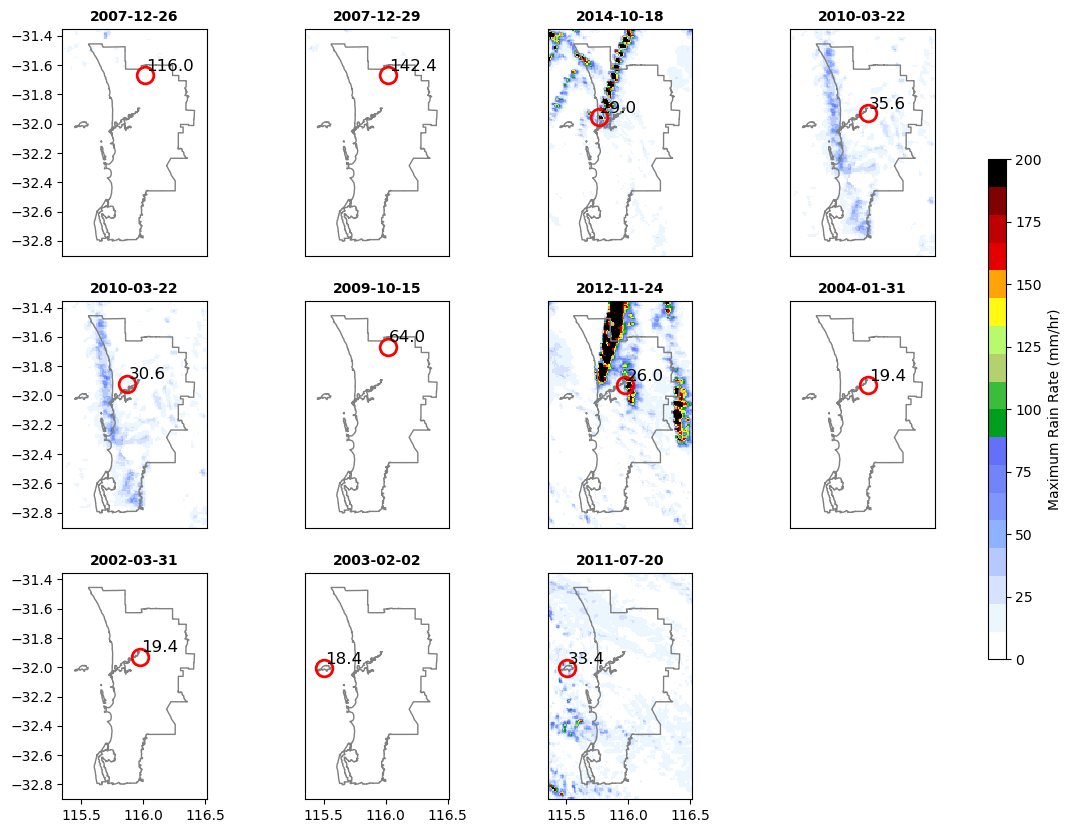

In [13]:
n = len(max_rain_rates)
ncols = 4
nrows = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 10))

for idx, ax in enumerate(axs.flat):
    if idx < n and max_rain_rates[idx] is not None:
        # Get event data
        event_time = pd.to_datetime(events_list.loc[idx, 'Time of 1hr P'])
        event_lat = events_list.loc[idx, 'Latitude']
        event_lon = events_list.loc[idx, 'Longitude']
        precip_value = events_list.loc[idx, 'Precipitation at 1hr']
        selected_date = event_time.strftime('%Y-%m-%d')
    
        data = max_rain_rates[idx]  # DataArray with dims (y, x)

        # pull the 2D coords by their actual names:
        lon2d = ds['longitude'].values  # shape (y, x)
        lat2d = ds['latitude'].values   # shape (y, x)

        # reduce to 1D
        lon_1d = lon2d[0, :]
        lat_1d = lat2d[:, 0]

        # compute edges
        lon_edges = np.linspace(lon_1d.min(), lon_1d.max(), len(lon_1d) + 1)
        lat_edges = np.linspace(lat_1d.min(), lat_1d.max(), len(lat_1d) + 1)

        # plot
        mesh = ax.pcolormesh(lon_edges, lat_edges, data.values, shading='auto', cmap=custom_cmap, vmin=0, vmax=200)

        # Overlay Sydney polygon
        sydney_polygon.plot(ax=ax, color='none', edgecolor='grey')

        # Plot event location
        ax.plot(event_lon, event_lat, marker='o', markersize=12, markerfacecolor='none',
                markeredgecolor='red', markeredgewidth=2)

        # Annotate event precipitation
        ax.text(event_lon + 0.01, event_lat + 0.03, f'{precip_value:.1f}', color='black', fontsize=12,
                bbox=dict(facecolor='none', edgecolor='none', alpha=0.7))

        # Set spatial bounds to Sydney region
        minx, miny, maxx, maxy = sydney_polygon.total_bounds
        ax.set_xlim(minx - 0.1, maxx + 0.1)
        ax.set_ylim(miny - 0.1, maxy + 0.1)

        # Show x-axis ticks only for bottom row
        if idx // ncols == nrows - 1:
            ax.xaxis.set_visible(True)
            ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        else:
            ax.xaxis.set_visible(False)

        # Show y-axis ticks only for first column
        if idx % ncols == 0:
            ax.yaxis.set_visible(True)
            ax.tick_params(axis='y', which='both', left=True, right=False, labelleft=True)
        else:
            ax.yaxis.set_visible(False)

        # Set bold date title
        ax.set_title(f'{selected_date}', fontsize=10, weight='bold')
    else:
        ax.axis('off')

# Add a single shared colorbar (outside loop)
cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])
cbar = fig.colorbar(mesh, cax=cbar_ax)
cbar.set_label('Maximum Rain Rate (mm/hr)')
cbar_ax.set_xticks([])

# plt.savefig("/scratch/gb02/lk5320/python_scripts/BARRA/Perth_radar/b2_perth_radar_maps_1hr.png", dpi=300, bbox_inches='tight')

plt.show()


/jobfs/145594500.gadi-pbs/ipykernel_3771103/508538790.py:22: RuntimeWarning: All-NaN axis encountered
  combined_data = np.nanmax([max_rain_rates[i].values for i in indices if max_rain_rates[i] is not None], axis=0)
/jobfs/145594500.gadi-pbs/ipykernel_3771103/508538790.py:22: RuntimeWarning: All-NaN axis encountered
  combined_data = np.nanmax([max_rain_rates[i].values for i in indices if max_rain_rates[i] is not None], axis=0)
/jobfs/145594500.gadi-pbs/ipykernel_3771103/508538790.py:22: RuntimeWarning: All-NaN axis encountered
  combined_data = np.nanmax([max_rain_rates[i].values for i in indices if max_rain_rates[i] is not None], axis=0)
/jobfs/145594500.gadi-pbs/ipykernel_3771103/508538790.py:22: RuntimeWarning: All-NaN axis encountered
  combined_data = np.nanmax([max_rain_rates[i].values for i in indices if max_rain_rates[i] is not None], axis=0)
/jobfs/145594500.gadi-pbs/ipykernel_3771103/508538790.py:22: RuntimeWarning: All-NaN axis encountered
  combined_data = np.nanmax([max_r

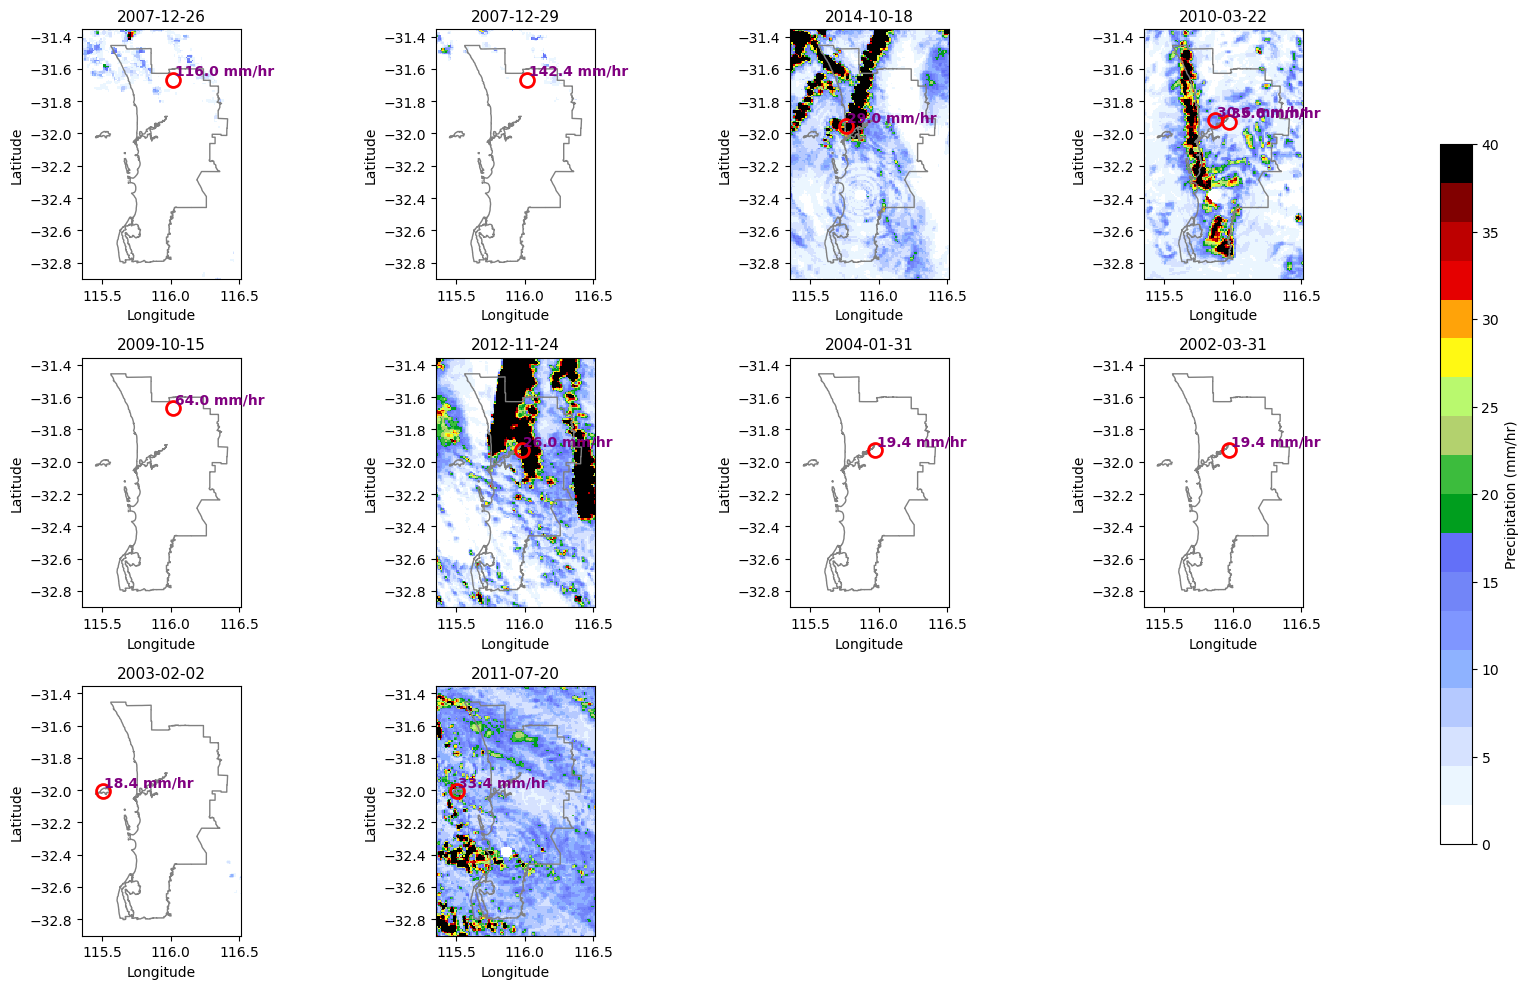

In [22]:
from collections import defaultdict

# Group events by date
grouped = defaultdict(list)
for idx, row in events_list.iterrows():
    date = pd.to_datetime(row['Time of 1hr P']).date()
    grouped[date].append(idx)

# Prepare figure
dates = list(grouped.keys())
n = len(dates)
ncols = 4
nrows = int(np.ceil(n / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(16, 10))
axs = axs.flatten()

for plot_idx, date in enumerate(dates):
    ax = axs[plot_idx]
    indices = grouped[date]

    # Combine data (e.g., take maximum over multiple entries on same date)
    combined_data = np.nanmax([max_rain_rates[i].values for i in indices if max_rain_rates[i] is not None], axis=0)

    # Get reference from first index
    i0 = indices[0]
    lon2d = ds['longitude'].values
    lat2d = ds['latitude'].values
    lon_1d = lon2d[0, :]
    lat_1d = lat2d[:, 0]
    lon_edges = np.linspace(lon_1d.min(), lon_1d.max(), len(lon_1d) + 1)
    lat_edges = np.linspace(lat_1d.min(), lat_1d.max(), len(lat_1d) + 1)

    # Plot
    mesh = ax.pcolormesh(lon_edges, lat_edges, combined_data, shading='auto', cmap=custom_cmap, vmin=0, vmax=40)
    sydney_polygon.plot(ax=ax, color='none', edgecolor='grey')

    # Plot all event points for the day
    for idx in indices:
        event = events_list.loc[idx]
        event_lon = event['Longitude']
        event_lat = event['Latitude']
        precip_value = event['Precipitation at 1hr']
        ax.plot(event_lon, event_lat, marker='o', markersize=10, markerfacecolor='none',
                markeredgecolor='red', markeredgewidth=2)
        ax.text(event_lon + 0.01, event_lat + 0.03, f'{precip_value:.1f} mm/hr',
                color='k', fontsize=10, fontweight='bold')

    # Set spatial bounds and formatting
    minx, miny, maxx, maxy = sydney_polygon.total_bounds
    ax.set_xlim(minx - 0.1, maxx + 0.1)
    ax.set_ylim(miny - 0.1, maxy + 0.1)
    ax.set_title(str(date), fontsize=11)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

# Turn off unused axes
for ax in axs[n:]:
    ax.set_visible(False)

# Add a shared colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1])
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mesh, cax=cbar_ax, orientation='vertical')
cbar.set_label('Precipitation (mm/hr)')

# Save if needed
# plt.savefig("perth_radar_combined_by_date.png", dpi=300, bbox_inches='tight')
plt.savefig(f"{base_path}/figure/{region_name}_radar_top10_subplot_separate_day_reorder.jpg", dpi=300, bbox_inches='tight')

plt.show()
